# Data Challenge - Week 5
## Breast Cancer Detection

Uses Wisconsin breast cancer dataset to identify features most predictive for malignant cells

## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

## Load and clean data

In [2]:
dir_name = '/Users/mbeckert/Documents/code/insight_testing/data_challenges/week5'

In [3]:
# Read in the data:
# We are using the Index column to match up with dataframe 
# and omitting the ID column to make the cleaning a little easier 
b_df = pd.read_csv('breast-cancer-wisconsin.txt', 
                   index_col = 'Index', 
                   usecols = lambda column : column not in ['ID'])


In [4]:
# We have some missing values
# But they are so few we will just omit them from our analysis

print('Number of rows with missing values ', b_df.shape[0] - b_df.dropna().shape[0])
print('Number of total items ', b_df.shape[0])

# Remake DataFrame without the rows with missing values
b_df = b_df.dropna()

Number of rows with missing values  28
Number of total items  15855


In [5]:
# Next some entries, rather than just omitting the results have "No idea" written
# Find these and remove them
# This again occurs rarely
print('Number of times "No idea" is written out: ', sum(b_df['Bare Nuclei'].isin(['No idea'])))
b_df = b_df.drop(b_df[b_df['Bare Nuclei'] == 'No idea'].index)

# Some entries also have '#' as values
print('Number of times "#" is written out: ', sum(b_df['Bare Nuclei'].isin(['#'])))
b_df = b_df.drop(b_df[b_df['Bare Nuclei'] == '#'].index)

# Some entries also have '?' as values
print('Number of times "?" is written out: ', sum(b_df['Bare Nuclei'].isin(['?'])))
b_df = b_df.drop(b_df[b_df['Bare Nuclei'] == '?'].index)

Number of times "No idea" is written out:  17
Number of times "#" is written out:  11
Number of times "?" is written out:  39


In [6]:
# Most of the columns are in string format because of the various elements we had to remove above
# Need to quickly change their dtypes of them
b_df = b_df.applymap(lambda x: int(str(x)))

In [7]:
# Another cleaning step:
# All values should be between 1-10, but some are multiplied by 10...
# Identify those rows and divide by 10

print('Rows with scores over 10: ', sum(b_df.max(axis=1) > 10))

b_df.loc[b_df.max(axis=1) > 10] = b_df.loc[b_df.max(axis=1) > 10] / 10

Rows with scores over 10:  156


In [8]:
b_df['Class'].loc[b_df['Class'] == 2.0] = 0.0
b_df['Class'].loc[b_df['Class'] == 4.0] = 1.0

In [9]:
# Now we should have a clean dataset
b_df.describe()

Clump Thickness  Uniformity of Cell Size  Uniformity of Cell Shape  \
count     15760.000000             15760.000000              15760.000000   
mean          7.587373                 6.893909                  5.621827   
std           2.162884                 2.466485                  2.130135   
min           1.000000                 1.000000                  1.000000   
25%           7.000000                 5.000000                  4.000000   
50%           8.000000                 6.000000                  5.000000   
75%          10.000000                10.000000                  7.000000   
max          10.000000                10.000000                 10.000000   

       Marginal Adhesion  Single Epithelial Cell Size   Bare Nuclei  \
count       15760.000000                 15760.000000  15760.000000   
mean            5.034518                     4.221383      6.462881   
std             2.909721                     2.097088      3.222449   
min             1.000000                     1.000000      1.000000   
25%             3.000000                     3.000000      3.000000   
50%             4.000000                     4.000000      8.000000   
75%             7.000000                     4.000000     10.000000   
max            10.000000                    10.000000     10.000000   

       Bland Chromatin  Normal Nucleoli       Mitoses         Class  
count     15760.000000     15760.000000  15760.000000  15760.000000  
mean          4.614150         4.971701      1.665736      0.971637  
std           1.895932         2.816730      1.505560      0.166013  
min           1.000000         1.000000      1.000000      0.000000  
25%           3.000000         3.000000      1.000000      1.000000  
50%           4.000000         5.000000      1.000000      1.000000  
75%           7.000000         8.000000      2.000000      1.000000  
max          10.000000        10.000000     10.000000      1.000000

-----------------------

# Let's do some exploration of the data

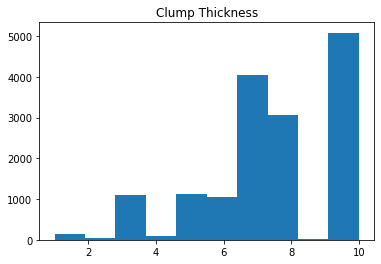

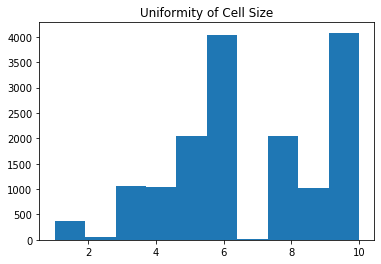

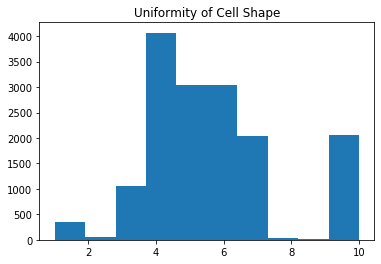

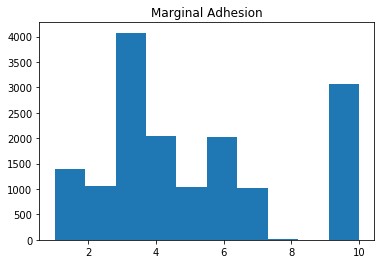

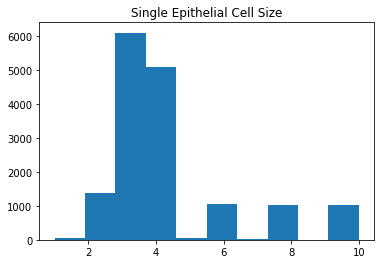

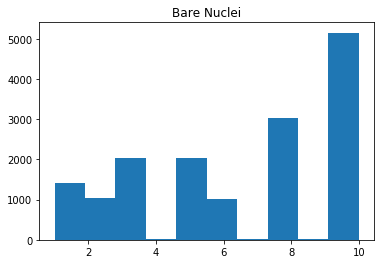

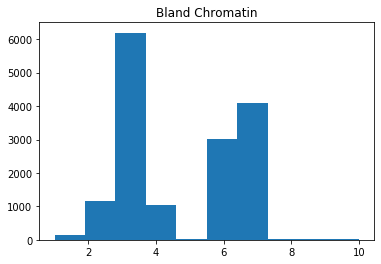

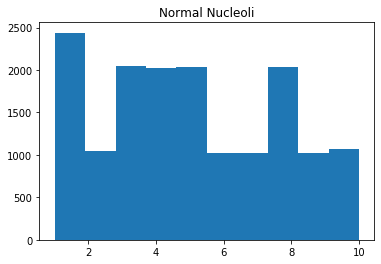

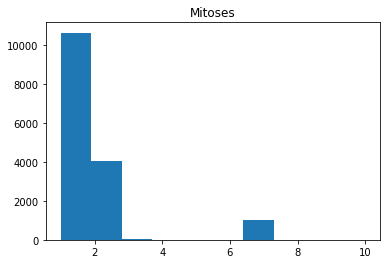

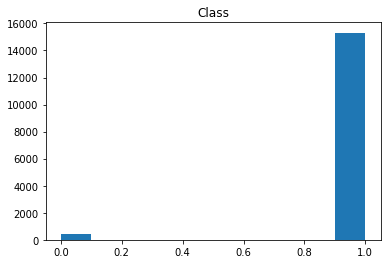

In [10]:
# Some histograms

for i, x in enumerate(b_df.keys()):
    plt.figure()
    plt.hist(b_df[x])
    plt.title(x)

Most interesting here is that we have a large disparity in occurrences of benign (0) and malignant (1) tumors.
Going to need to consider this when generating model

In [11]:
print('Class imbalance: Most tests return "Malignant": ', np.round(sum(b_df['Class'] == 1.0) / len(b_df) * 100, 2))

Class imbalance: Most tests return "Malignant":  97.16


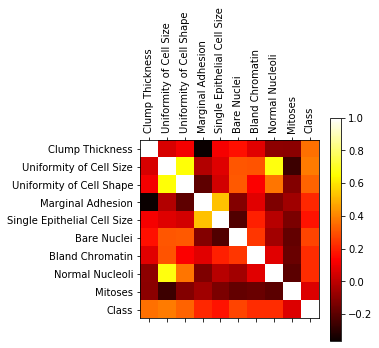

In [12]:
# Let's also look at any potential correlations in the data
plt.matshow(b_df.corr(), cmap='hot')
plt.colorbar()
plt.xticks(range(len(b_df.keys())), b_df.keys(), rotation=90)
plt.yticks(range(len(b_df.keys())), b_df.keys())
plt.show()

Correlation is moderately strong between "Uniformity" of cell shape and size, 
As well as Marginal adhesion and Single epithelial cell size
And Uniformity of Cell Size with Normal Nucleoli

Consider these when identifying the most informative features for our model

---------------

# Logistic regression

Selecting logistic regression because of its utility in classification problems and interpretability

In [13]:
# Make train, validate, test splits

X, y = b_df.drop(columns='Class').values, b_df['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [14]:
from sklearn.linear_model import LogisticRegression

# clf = LogisticRegression(random_state=0, solver='lbfgs',
#                          multi_class='multinomial').fit(X_train, y_train)
clf = LogisticRegression(random_state=0, solver='liblinear').fit(X_train, y_train)

print('Logistic regression: Score: ', np.round(clf.score(X_test, y_test) * 100, 2))

Logistic regression: Score:  99.87


In [15]:
pred = clf.predict(X_test)

print('recall = ', np.round(recall_score(y_test, pred)*100, 2))
print('precision = ', np.round(precision_score(y_test, pred)*100, 2))

recall =  99.97
precision =  99.9


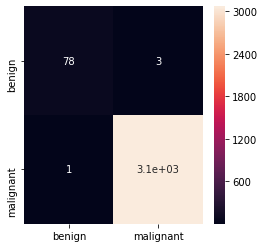

In [16]:
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), 
    index = ['benign', 'malignant'], 
    columns = ['benign', 'malignant'])

plt.figure(figsize = (4,4))
sn.heatmap(df_cm, annot=True)

This model is doing amazingly well. 

But as we noted in our exploration, there are a massive group imbalance between benign and malignant.
Our model likely learned just to classify everything as malignant and it will still do very well.
Evident in having a bunch of false positives.

Recall that we had 97% of the cases return "malignant"
Our performance here is likely just describing the distribution in our dataset.

So we will need to rethink our model to ensure our datasets are balanced

----

It is here that we may consider why this imbalance occurred.

Is it that 97% of all biopsies will return malignant, meaning that a woman with a lump in her breast has 97% chance of it being malignant!?

I hope that is not the case. Rather this is likely due to the doctor's training. He/she is likely to want to wait and monitor the lump for some time if it is small and therefore likely to be benign. Thereby foregoing unnecessary stress and costs for his/her patient by having to have the biopsy.

So the doctors' training and general approach to handling patients injects a heavy bias into our dataset.

Reworking our model with imperfect data would be preferential to having doctors simply order more biopsies to gather a more realistic distribution. Causing undue stress, discomfort, and costs for the patient for the sake of the data scientist.

------

# Balancing the classes

We will now want to try and balance the classes in the training data set and see how that affects our model

In [17]:
# Import the imbalanced-learn package,
# which provides numerous ways to overcome the class imbalance problem
# Here we will start with the most basic approach,
# randomly resample values from the minority group with replacement to generate balanced classes
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

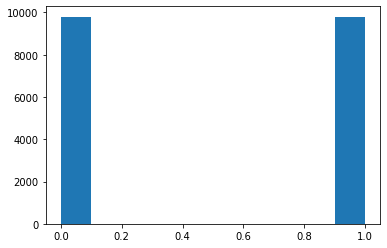

In [18]:
plt.hist(y_resampled)
plt.show()

Great! We have balanced classes for our training data.
Let's see how the model handles this now!

In [19]:
clf = LogisticRegression(random_state=0, solver='liblinear').fit(X_resampled, y_resampled)

print('Logistic regression: Score: ', np.round(clf.score(X_test, y_test) * 100, 2))

Logistic regression: Score:  99.87


In [20]:
pred = clf.predict(X_test)

print('recall = ', np.round(recall_score(y_test, pred)*100, 2))
print('precision = ', np.round(precision_score(y_test, pred)*100, 2))

recall =  99.9
precision =  99.97


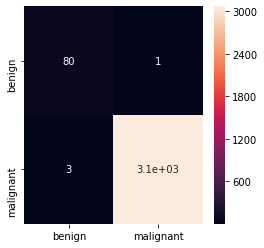

In [21]:
df_cm = pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test)), 
    index = ['benign', 'malignant'], 
    columns = ['benign', 'malignant'])

plt.figure(figsize = (4,4))
sn.heatmap(df_cm, annot=True)

The model is still doing a great job, even when we balance the training dataset. With only a couple more occurrences in our false negative group.

--------

## What features should we focus on to save resources?

In [22]:
# Let's look at the coefficients to see which are the most influential in our model
var_co = pd.DataFrame({'features': b_df.keys()[:-1], 'coefficients':clf.coef_[0]})
print(var_co)

                      features  coefficients
0              Clump Thickness      0.781595
1      Uniformity of Cell Size      0.574933
2     Uniformity of Cell Shape      0.240638
3            Marginal Adhesion      0.914278
4  Single Epithelial Cell Size     -0.546669
5                  Bare Nuclei      0.260574
6              Bland Chromatin      0.177477
7              Normal Nucleoli      0.215690
8                      Mitoses      0.830900


Looks like "Mitoses", "Marginal Adhesion", and "Clump Thickness" are the most important.
We should recommend to focus on these three for analysis in the future to save costs while maximizing accuracy

In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98        81
         1.0       1.00      1.00      1.00      3071

    accuracy                           1.00      3152
   macro avg       0.98      0.99      0.99      3152
weighted avg       1.00      1.00      1.00      3152



## Running Logistic regression with reduced features

In [24]:
# Make train, validate, test splits
# And over-sample to balance the training set

X, y = b_df[['Mitoses', 'Marginal Adhesion', 'Clump Thickness']].values, b_df['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [25]:
clf = LogisticRegression(random_state=0, solver='liblinear').fit(X_resampled, y_resampled)

print('Logistic regression: Score: ', np.round(clf.score(X_test, y_test) * 100, 2))

Logistic regression: Score:  99.68


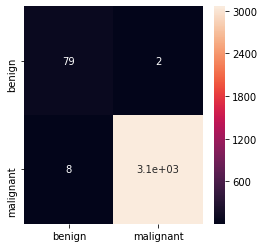

In [26]:
df_cm = pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test)), 
    index = ['benign', 'malignant'], 
    columns = ['benign', 'malignant'])

plt.figure(figsize = (4,4))
sn.heatmap(df_cm, annot=True)

In [27]:
# Let's look at the coefficients to see which are the most influential in our model
var_co = pd.DataFrame({'features': ['Mitoses', 'Marginal Adhesion', 'Clump Thickness'], 'coefficients':clf.coef_[0]})
print(var_co)

            features  coefficients
0            Mitoses      1.385054
1  Marginal Adhesion      1.226790
2    Clump Thickness      2.051189


Performance using these few key features is still good

-------

# Conclusions

Here we present a model which can predict whether the tissue from a breast biopsy is benign or malignant.

The model performs very well, even after ensuring the balance for classes.

The important features appeared to be "Clump Thickness", "Mitoses", and "Marginal Adhesion" which can be targeted alone to save on costs of performing these tests.
Intuitively, larger values for these 3 features increases the probability we suspect malignancy.

Below is a simple tool a doctor could use to test if a sample is benign or malignant given the 3 primary features

------------

# Tool for doctors

This is a basic example of a tool a doctor could use to incorporate this model into his/her workflow

All the doctor has to do is input the values returned from the biopsy in order:
{Mitoses score, Marginal Adhesion score, Clump thickness score}

The model will then perform a prediction and return a statement

In [28]:
# Set up model
X, y = b_df[['Mitoses', 'Marginal Adhesion', 'Clump Thickness']].values, b_df['Class'].values
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)
clf = LogisticRegression(random_state=0, solver='liblinear').fit(X_resampled, y_resampled)

# Define tool
def test_for_malignancy(values):
    result = clf.predict_proba([values])
    print('Probability Malignant: ', str(np.round(result[0][1] * 100, 2)))
        

In [29]:
# Doctor inputs values from biopsy test here
values = [1, 1, 1]

test_for_malignancy(values)

Probability Malignant:  0.0


In [30]:
values = [5, 8, 2]

test_for_malignancy(values)

Probability Malignant:  84.88
